In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import gensim
import spacy
import string
import core.model_utils as model_utils
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [2]:
df = pd.read_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens.json')
df.rename(columns={'emotions': 'label', 'text_pl': 'text'}, inplace=True)
df

,label,text,tokens,joined_tokens
0,anger,Czuję się całkowicie chciwy,"[czuję, całkowicie, chciwy]",czuję całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami,"[czuję, przytłocić, emocja]",czuję przytłocić emocja
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...,"[nie, czuć, być, efekt, siła, g, oszołomiona, ...",nie czuć być efekt siła g oszołomiona poszedłe...
3,anger,ive just got to tell you all that I feel Racze...,"[ive, just, got, tell, you, all, that, feel, r...",ive just got tell you all that feel raczej nie...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si...","[powiedzieć, być, przepraszać, czuć, sfrustrow...",powiedzieć być przepraszać czuć sfrustrowany z...
...,...,...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj...","[czuć, ostatnio, hojny, pracować, znacznie, zw...",czuć ostatnio hojny pracować znacznie zwykle z...
39996,love,"Czuję, że niektóre postacie nie zasługują na w...","[czuję, niektóry, postać, nie, zasługiwać, wsp...",czuję niektóry postać nie zasługiwać wsparcie ...
39997,fear,"Czuję strach w moich kościach, którego nie moż...","[czuję, strach, kość, nie, móc, wytrząsnąć, wy...",czuję strach kość nie móc wytrząsnąć wymuszć r...
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...,"[czuć, być, kreatywny, czysty, redaktor]",czuć być kreatywny czysty redaktor


In [3]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

df = df.replace({"label": ordered_class_labels})

In [4]:
full_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['label', 'text', 'tokens', 'joined_tokens'],
    num_rows: 40000
})

In [5]:
# Train set: 80%, Validation set: 10%, Test set: 10%
_, _, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)
test_dataset

Dataset({
    features: ['label', 'text', 'tokens', 'joined_tokens'],
    num_rows: 4000
})

In [6]:
# Load models
version = "1"
trained_bert = os.path.join("./../trained_models/emotions_pl_bert_5", version)
trained_gpt = os.path.join("./../trained_models/emotions_pl_gpt2_2", version)
trained_0_1_binary_word2vec_external = os.path.join("./../trained_models/emotions_pl_word2vec_binary_0_1_external_2",
                                                    version)

bert = tf.keras.models.load_model(trained_bert)
gpt2 = tf.keras.models.load_model(trained_gpt)
word2vec_0_1 = tf.keras.models.load_model(trained_0_1_binary_word2vec_external)

In [7]:
# Create BERT tokenizer and collator
bert_checkpoint = "dkleczek/bert-base-polish-uncased-v1"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint, model_max_length=512)


def tokenize_for_bert(example):
    return bert_tokenizer(example["text"], truncation=True)


bert_tokenized_test_dataset = test_dataset.map(tokenize_for_bert, batched=True)

bert_input_columns = ["attention_mask", "input_ids", "token_type_ids"]
bert_label_columns = ['label']
bert_batch_size = 16
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, return_tensors="tf")
bert_tf_dataset = model_utils.convert_to_tf_dataset(bert_tokenized_test_dataset, bert_input_columns, bert_label_columns,
                                                    bert_data_collator, bert_batch_size)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [8]:
# Create GPT2 tokenizer
gpt_checkpoint = MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

gpt2_tokenizer.padding_side = "left"


def tokenize_for_gpt2(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text']]

    output = gpt2_tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


gpt2_tokenized_test_dataset = test_dataset.map(tokenize_for_gpt2, batched=True)

gpt2_input_columns = ["input_ids", "attention_mask"]
gpt2_label_columns = ["label"]
gpt2_batch_size = 16
gpt2_data_collator = DataCollatorWithPadding(tokenizer=gpt2_tokenizer, return_tensors="tf")
gpt2_tf_dataset = model_utils.convert_to_tf_dataset(gpt2_tokenized_test_dataset, gpt2_input_columns, gpt2_label_columns,
                                                    gpt2_data_collator, gpt2_batch_size)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [9]:
# Create Word2Vec external tokenizer
word2vec_external_kv = gensim.models.KeyedVectors.load("./word2vec/word2vec_100_3_polish.bin")


def tokens_to_vector_external(tokens):
    vector_size = word2vec_external_kv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in tokens:
        if w in word2vec_external_kv:
            ctr += 1
            wv_res += word2vec_external_kv[w]
    wv_res = wv_res / ctr
    return wv_res


def tokenize_for_word2vec_external(sample):
    sample['embeddings'] = [tokens_to_vector_external(tokens) for tokens in sample['tokens']]
    return sample


word2vec_external_test_dataset = test_dataset.map(tokenize_for_word2vec_external, batched=True)

word2vec_external_input_columns = ["embeddings"]
word2vec_external_label_columns = ["label"]
word2vec_external_batch_size = 16
word2vec_external_tf_dataset = model_utils.convert_to_tf_dataset(word2vec_external_test_dataset,
                                                                 word2vec_external_input_columns,
                                                                 word2vec_external_label_columns,
                                                                 None, word2vec_external_batch_size)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [25]:
def combine_probabilities(model1_probabilities, model2_probabilities, model3_probabilities, model1_weights,
                          model2_weights):
    weighted_avg_probabilities = (
                                         model1_weights * model1_probabilities + model2_weights * model2_probabilities) / (
                                         model1_weights + model2_weights)
    normalized_probabilities = weighted_avg_probabilities / np.sum(weighted_avg_probabilities, axis=1, keepdims=True)


    for index, proba in enumerate(normalized_probabilities):
        if np.argmax(proba) == 1:
            proba = np.zeros(6)
            proba[0] = model3_probabilities[index][0]
            proba[1] = model3_probabilities[index][1]
            normalized_probabilities[index] = proba

    return normalized_probabilities


def hybrid_predict(bert_input, gpt2_input, word2vec_0_1_input, bert_model, gpt2_model, word2vec_0_1_model, bert_weights,
                   gpt2_weights, return_classes=True):
    bert_probabilities = model_utils.get_class_preds(bert_model, bert_input, return_classes=False)
    gpt2_probabilities = model_utils.get_class_preds(gpt2_model, gpt2_input, return_classes=False)
    word2vec_0_1_probabilities = model_utils.get_class_preds(word2vec_0_1_model, word2vec_0_1_input,
                                                             return_classes=False, model_returns_logits=False)

    final_output = combine_probabilities(bert_probabilities, gpt2_probabilities, word2vec_0_1_probabilities,
                                         bert_weights, gpt2_weights)
    if return_classes:
        final_output = np.argmax(final_output, axis=1)
    return final_output

In [26]:
bert_weights = np.array([88, 88, 88, 87, 94, 76])
gpt2_weights = np.array([91, 82, 87, 81, 92, 84])

hybrid_preds = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset, word2vec_0_1_input=word2vec_external_tf_dataset,
    bert_model=bert, gpt2_model=gpt2, word2vec_0_1_model=word2vec_0_1,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights
)

hybrid_probas = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset, word2vec_0_1_input=word2vec_external_tf_dataset,
    bert_model=bert, gpt2_model=gpt2, word2vec_0_1_model=word2vec_0_1,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights,
    return_classes=False
)

In [27]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['label'],
    class_preds=hybrid_preds,
    average='micro'
)

accuracy = accuracy_score(test_dataset['label'], hybrid_preds)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
loss = loss(test_dataset['label'], hybrid_probas).numpy()

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)
print(f"Accuracy: ", accuracy)
print(f"Loss: ", loss)

Precision score:  0.8435
Recall score:  0.8435
F1 score:  0.8435
Accuracy:  0.8435
Loss:  0.5566845536231995


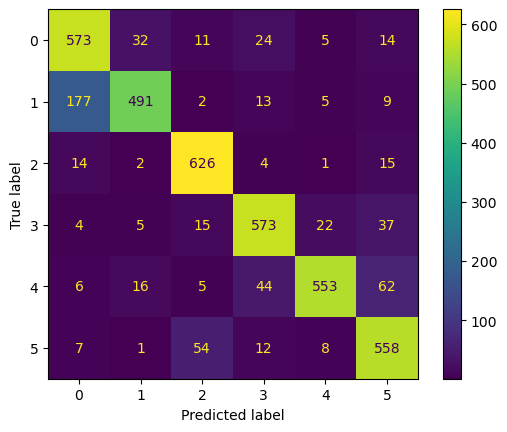

In [29]:
training_name = "binary_0_1_word2vec_trusted"
figures_dir = "./../documentation/models/emotions_pl_hybrid/figures"

model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['label'],
                                      class_preds=hybrid_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [30]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['text'],
                                              class_actual=test_dataset['label'],
                                              class_preds=hybrid_preds,
                                              number_of_incorrect_preds=100)


            BAD PREDICTION:
            - INDEX: 6
            - TEXT: Nie wiem, jak kilka zdań może sprawić, że ludzie, którzy je czytają, natychmiast wiedzą, co naprawdę myślę lub czuję, a nikt nie zadał sobie trudu, aby zapytać mnie w twarz.
            - PREDICTED VALUE: 5
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 10
            - TEXT: Nie chcę listopada daleko lub próbuje zapomnieć o Święto Dziękczynienia, ale muszę być świadomy tego, co naprawdę się liczy, gdy czuję się przytłoczony
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 5
            

            BAD PREDICTION:
            - INDEX: 11
            - TEXT: Wolę złuszczacz mieć mikro drobne ziarna, ponieważ czuję, że jest to znacznie bardziej delikatne i nie ryzykujesz niechcianych zadrapań od większych cząstek
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 20
            - T

In [31]:
test_df = pd.DataFrame(
    list(zip(test_dataset['text'], test_dataset['label'], hybrid_preds)),
    columns=['text', 'label', 'prediction'])
test_df

,text,label,prediction
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,5
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,2
...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,5
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,2


In [32]:
def map_token_counts(row):
    return len(row['text'].split())


def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"


def map_correctly_predicted(row):
    return int(row['label'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text,label,prediction,token_count,count_belonging,correctly_predicted
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,5,13,12-17,1
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5,21,18-23,1
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1,16,12-17,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2,11,6-11,1
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,2,17,12-17,1
...,...,...,...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0,6,6-11,1
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4,12,12-17,1
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,5,22,18-23,0
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,2,9,6-11,1


In [33]:
test_df = test_df.drop(test_df[test_df.token_count > 41].index)

In [34]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

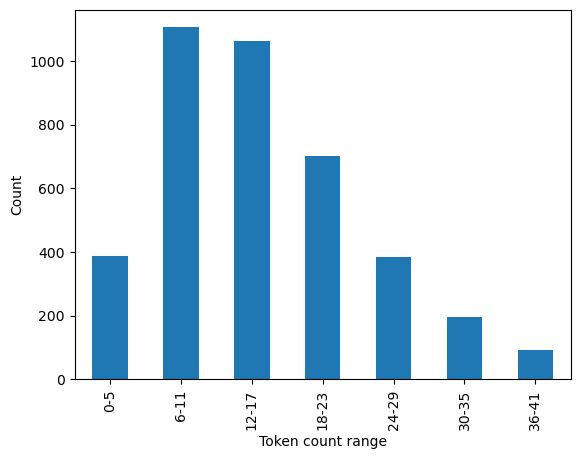

In [35]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [36]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0,
                                         '36-41': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0., '30-35': 0., '36-41': 0.}

In [37]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[
                                                                     count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 338, '6-11': 953, '12-17': 900, '18-23': 578, '24-29': 318, '30-35': 156, '36-41': 73}
Element count:  {'0-5': 386, '6-11': 1106, '12-17': 1064, '18-23': 702, '24-29': 383, '30-35': 197, '36-41': 93}
Accuracies:  {'0-5': 0.8756476683937824, '6-11': 0.8616636528028933, '12-17': 0.8458646616541353, '18-23': 0.8233618233618234, '24-29': 0.8302872062663186, '30-35': 0.7918781725888325, '36-41': 0.7849462365591398}


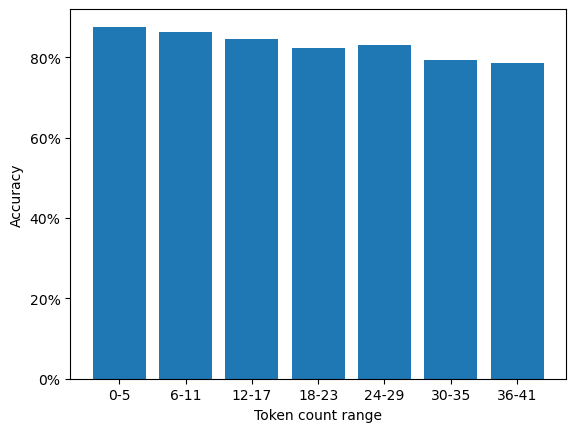

In [38]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29', '30-35', '36-41'],
        [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()